#### Version 01

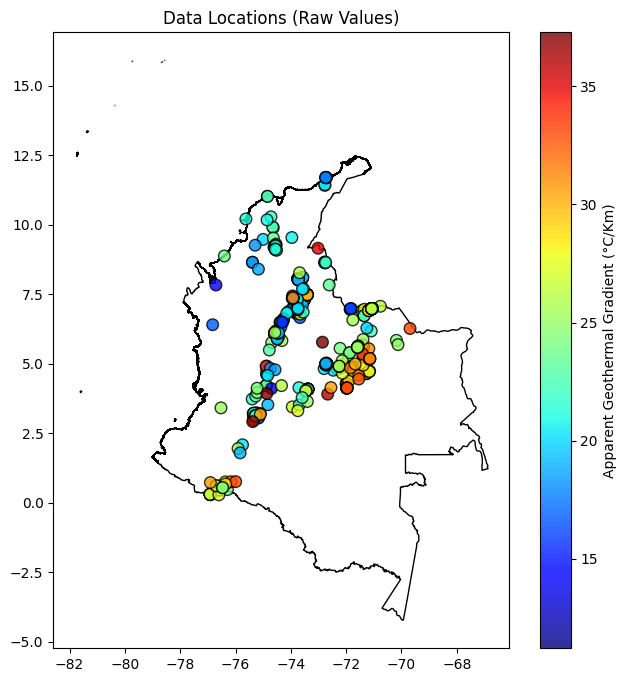

Fitted spherical model: len_scale=3.63, nugget=12.6160, sill=13.2628, MSE=9.9975e+02
Fitted exponential model: len_scale=1.05, nugget=4.8451, sill=21.3424, MSE=1.0030e+03
Fitted gaussian model: len_scale=0.40, nugget=9.9200, sill=14.5751, MSE=1.0024e+03

Variogram Fitting Metrics:
         model  len_scale     nugget       sill          MSE
0    spherical   3.626597  12.615974  13.262782   999.745001
1  exponential   1.047216   4.845107  21.342378  1002.973355
2     gaussian   0.397381   9.920014  14.575145  1002.407036

Best model selected: spherical
Parameters: len_scale=3.63, nugget=12.6160, sill=13.2628


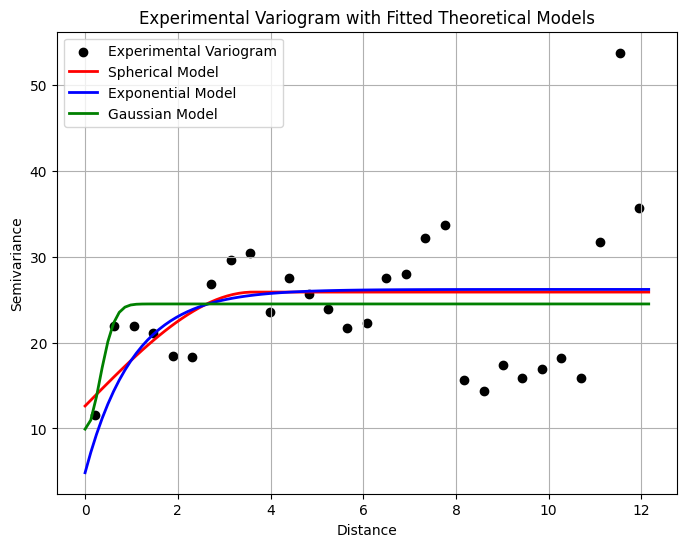

OK CV metrics: RMSE = 4.0771e+00, MAE = 3.0325e+00, R2 = 0.2925
SK CV metrics: RMSE = 4.0771e+00, MAE = 3.0325e+00, R2 = 0.2925
UK_AI CV metrics: RMSE = 3.8773e+00, MAE = 2.6787e+00, R2 = 0.3601
UK_linear CV metrics: RMSE = 3.9206e+00, MAE = 2.8947e+00, R2 = 0.3458
UK_quadratic CV metrics: RMSE = 4.0771e+00, MAE = 3.0325e+00, R2 = 0.2925

CV Metrics:
                  RMSE       MAE        R2
OK            4.077142  3.032493  0.292475
SK            4.077142  3.032493  0.292475
UK_AI         3.877315  2.678736  0.360129
UK_linear     3.920621  2.894685  0.345756
UK_quadratic  4.077142  3.032493  0.292475


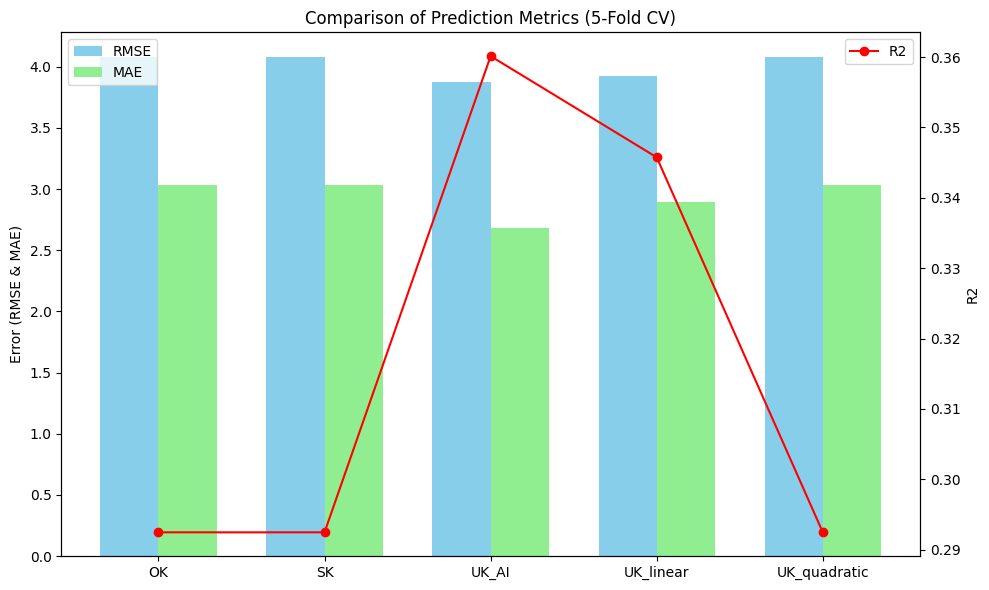

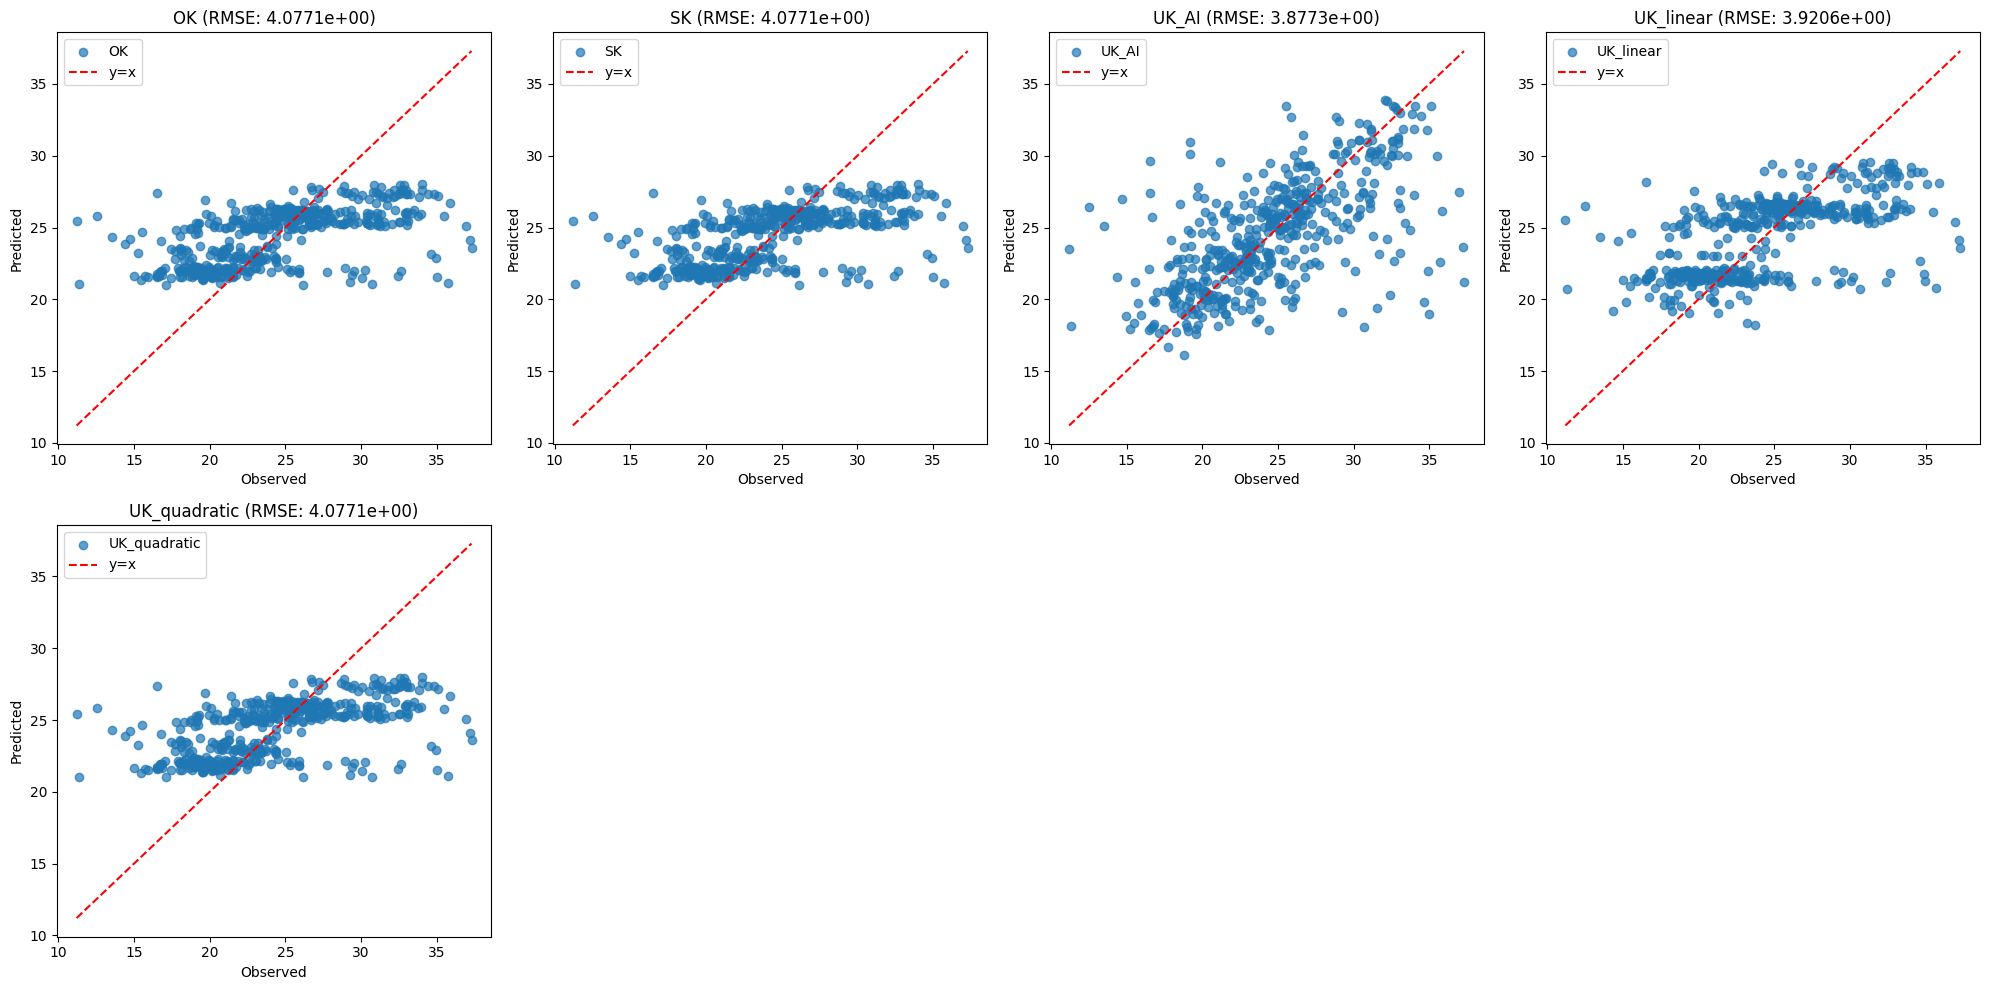


Best spatial interpolation model based on 5-fold CV: UK_AI with RMSE = 3.8773e+00


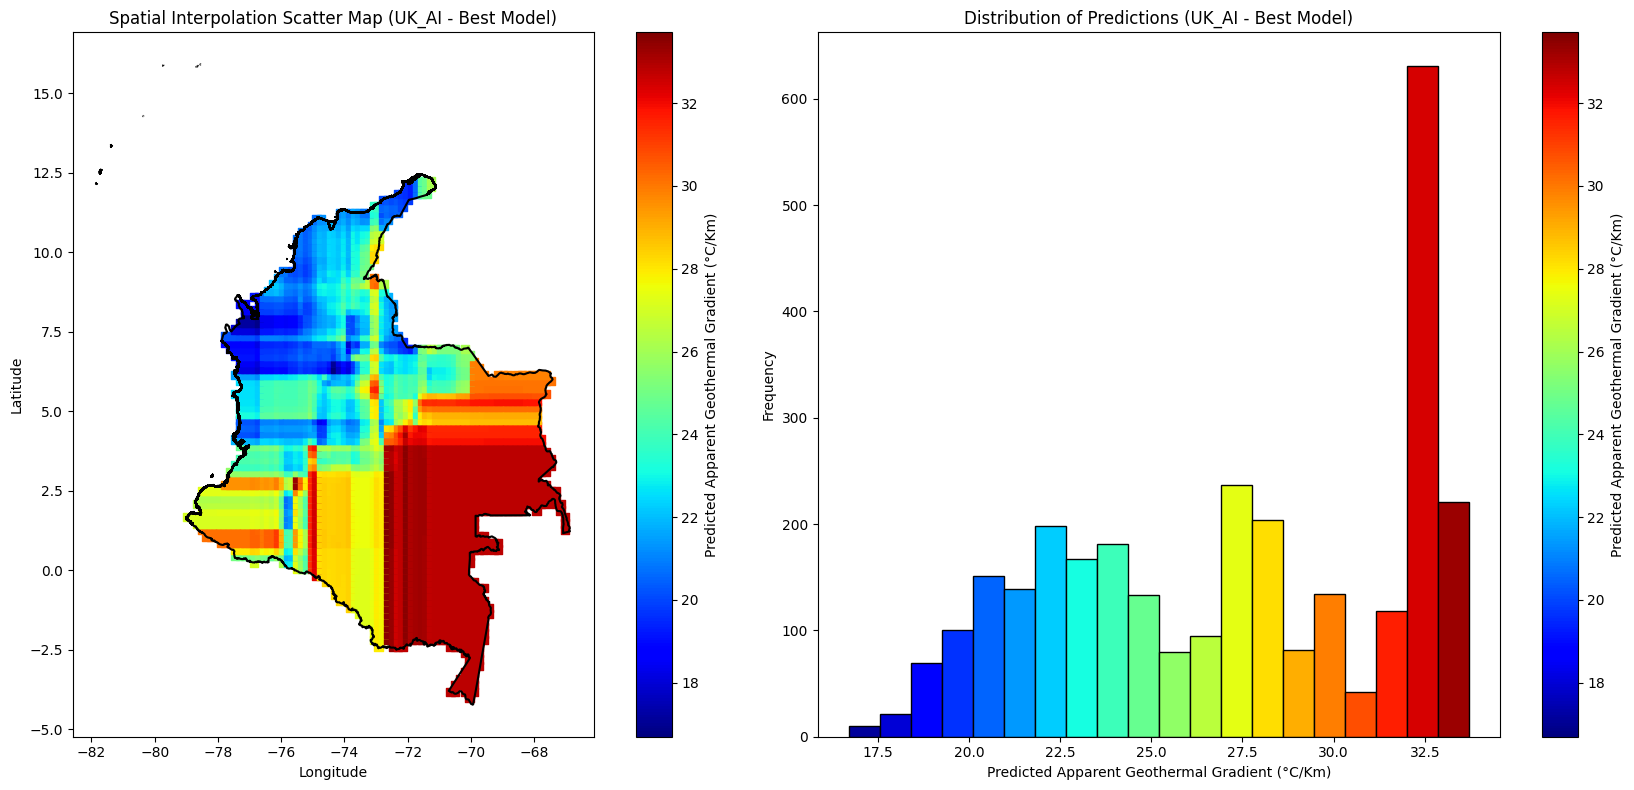

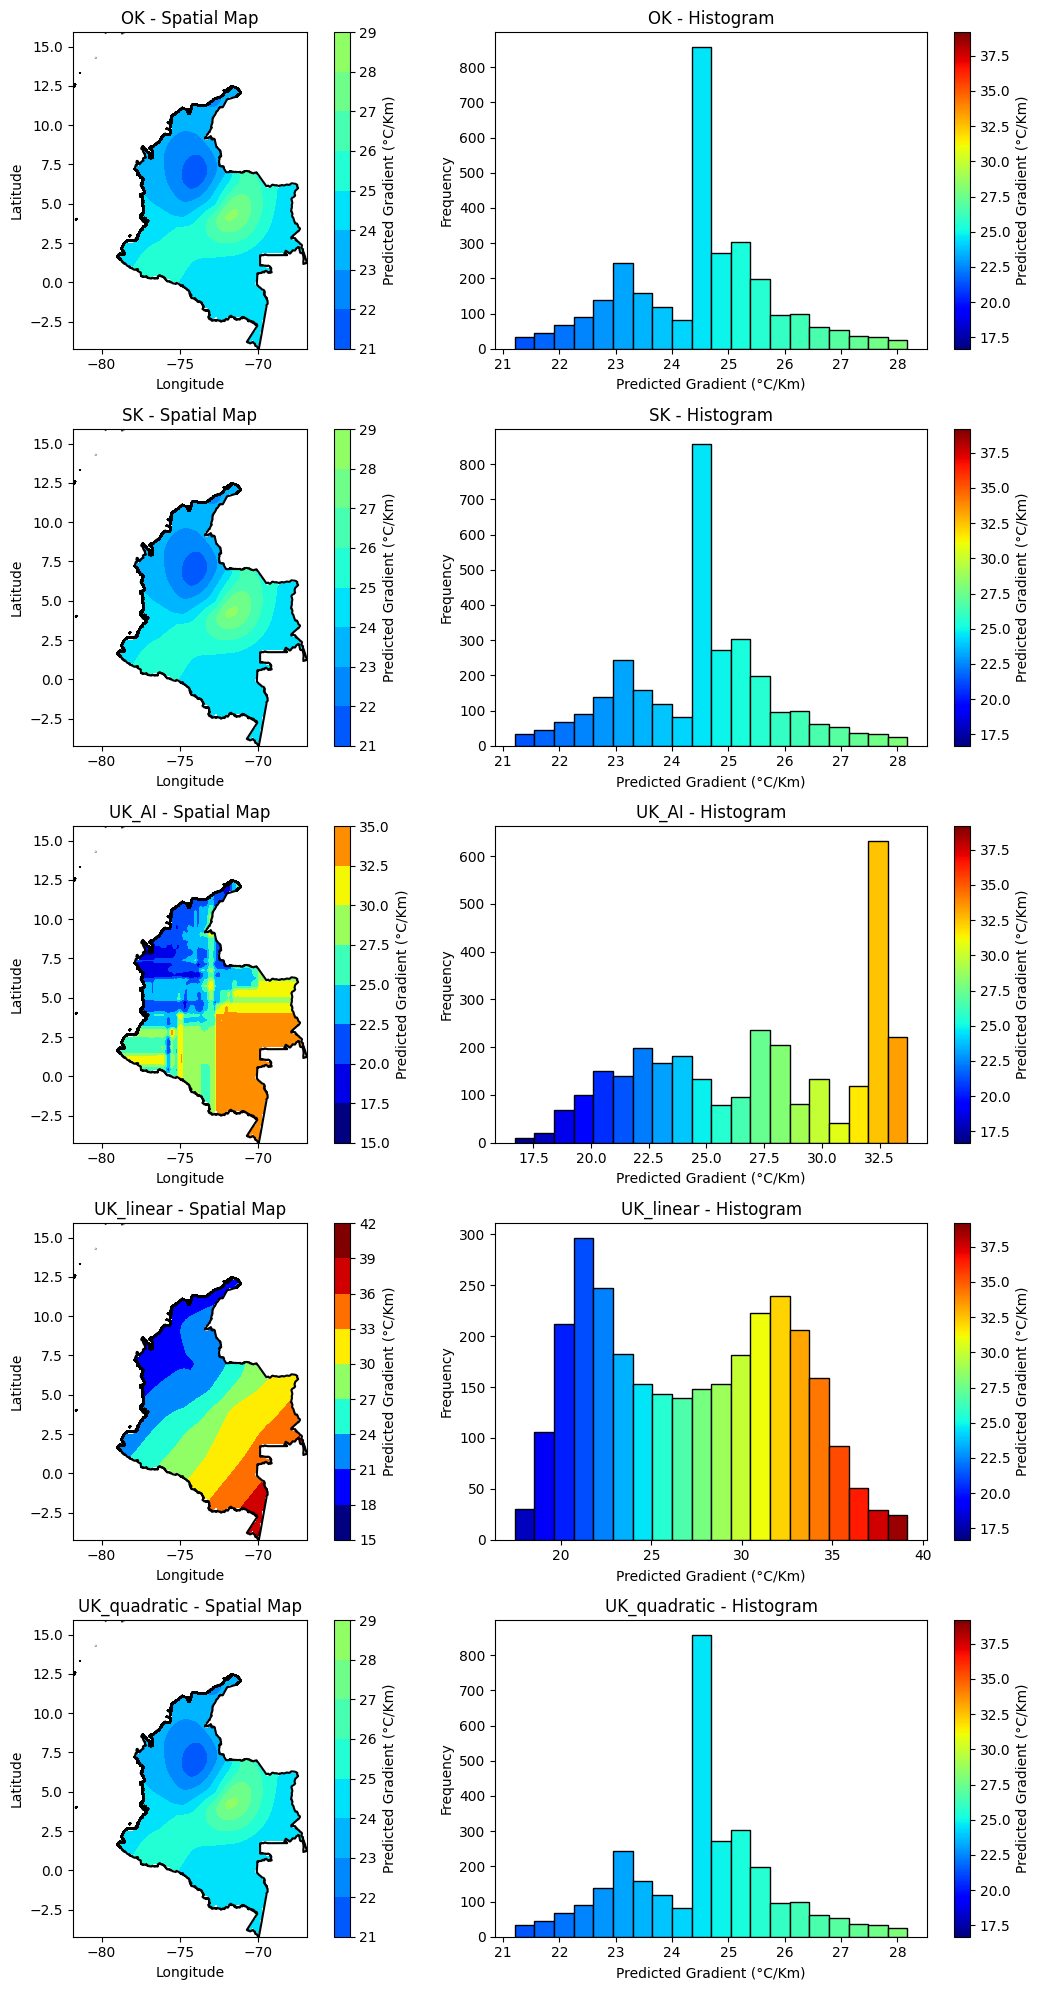


5-Fold Cross Validation Extended Metrics:
                  RMSE       MAE        R2
OK            4.077142  3.032493  0.292475
SK            4.077142  3.032493  0.292475
UK_AI         3.877315  2.678736  0.360129
UK_linear     3.920621  2.894685  0.345756
UK_quadratic  4.077142  3.032493  0.292475

Best spatial interpolation model based on 5-fold CV: UK_AI with RMSE = 3.8773e+00


In [5]:
"""
Complete Spatial Interpolation Workflow Script without Data Transformation
------------------------------------------------------------------------
This script:
1. Sets up output folders.
2. Loads data and the Colombia boundary; removes outliers.
3. Computes the experimental variogram (using original target values) and fits theoretical models.
4. Performs 5-fold cross-validation for several spatial interpolation methods (via models)
   and computes RMSE, MAE, and R² for each method.
   A dual-axis comparison plot and per-model CV scatter plots are generated.
5. Creates a prediction grid and performs full-dataset geostatistical interpolations (using original values).
6. Saves all full-grid interpolated values and CV metrics as CSV files.
7. Masks the interpolated grids to the Colombia boundary.
8. Plots a final scatter map and colored histogram (using the jet colormap) for the  model.
9. Plots spatial maps and histograms for each geostatistical method with a consistent color scale.
10. Prints the CV metrics.
"""

#########################################
# 0. Import Libraries and Suppress Warnings
#########################################
import os
import pickle
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import minimize
import gstools as gs
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.cm as cm
import matplotlib.colors as mcolors

#########################################
# 1. Setup Output Folders
#########################################
output_dir = "Output_03"
for subfolder in ["models", "plots", "results"]:
    os.makedirs(os.path.join(output_dir, subfolder), exist_ok=True)

#########################################
# 2. Load Data, Remove Outliers, and Load Colombia Boundary
#########################################
# Load a subset (first 500 rows) for speed.
data = pd.read_csv("Data/data_pre_norm.csv").head(500)

# --- Outlier Removal ---
# Remove outliers in the target variable using the IQR method.
target_var = "Apparent Geothermal Gradient (°C/Km)"
values_raw = data[target_var].values
Q1 = np.percentile(values_raw, 25)
Q3 = np.percentile(values_raw, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
mask = (values_raw >= lower_bound) & (values_raw <= upper_bound)
data = data[mask].reset_index(drop=True)

# Re-extract variables after filtering.
lat = data["Latitude"].values
lon = data["Longitude"].values
values = data[target_var].values  # use original values

# (No data transformation is applied here.)

# Stack coordinates as (lon, lat)
coords = np.vstack((lon, lat)).T

# Load the Colombia boundary shapefile.
colombia_boundary = gpd.read_file("./Data/COL_adm0.shp")
if colombia_boundary.crs is None:
    colombia_boundary.set_crs(epsg=4326, inplace=True)
else:
    colombia_boundary = colombia_boundary.to_crs("epsg:4326")

# --- Quick Data Display ---
fig, ax = plt.subplots(figsize=(8, 8))
colombia_boundary.plot(ax=ax, color='none', edgecolor='black')
sc = ax.scatter(lon, lat, c=values, cmap="jet", s=70, alpha=0.8, edgecolor='k')
ax.set_title("Data Locations (Raw Values)")
plt.colorbar(sc, ax=ax, label=target_var)
plt.savefig(os.path.join(output_dir, "plots", "data_locations_raw.png"))
plt.show()

#########################################
# 3. Compute Experimental Variogram and Fit Theoretical Models
#########################################
# Compute pairwise distances and semivariance using original target values.
dists = squareform(pdist(coords))
semivariance = 0.5 * (values[:, None] - values)**2

# Bin the experimental variogram for smoother plotting.
bin_edges = np.linspace(0, dists.max(), 30)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_vals = np.zeros_like(bin_centers)
for i in range(len(bin_edges) - 1):
    mask_bin = (dists.ravel() >= bin_edges[i]) & (dists.ravel() < bin_edges[i+1])
    if np.any(mask_bin):
        bin_vals[i] = np.mean(semivariance.ravel()[mask_bin])

def model_semivariance(model, h):
    return model.var + model.nugget - model.covariance(h)

theoretical_models = {
    "spherical": gs.Spherical,
    "exponential": gs.Exponential,
    "gaussian": gs.Gaussian
}
fitted_models = {}
metrics = []

def mse_model(params, model_class, distances, exp_var):
    model_instance = model_class(len_scale=params[0], nugget=params[1], var=params[2])
    y_pred = model_semivariance(model_instance, distances)
    return np.mean((y_pred - exp_var)**2)

initial_guess = [dists.max()/2, 0.0, np.var(values)]
bounds = [(1e-6, None), (0, None), (1e-6, None)]

for name, model_class in theoretical_models.items():
    res = minimize(mse_model, initial_guess, args=(model_class, dists.ravel(), semivariance.ravel()),
                   bounds=bounds)
    model_inst = model_class(len_scale=res.x[0], nugget=res.x[1], var=res.x[2])
    mse_val = res.fun
    fitted_models[name] = model_inst
    metrics.append({
        "model": name,
        "len_scale": res.x[0],
        "nugget": res.x[1],
        "sill": res.x[2],
        "MSE": mse_val
    })
    print(f"Fitted {name} model: len_scale={res.x[0]:.2f}, nugget={res.x[1]:.4f}, sill={res.x[2]:.4f}, MSE={mse_val:.4e}")

metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv(os.path.join(output_dir, "results", "variogram_fitting_metrics.csv"), index=False)
print("\nVariogram Fitting Metrics:")
print(metrics_df)

best_model_name = metrics_df.loc[metrics_df["MSE"].idxmin(), "model"]
best_model = fitted_models[best_model_name]
print(f"\nBest model selected: {best_model_name}")
print(f"Parameters: len_scale={best_model.len_scale:.2f}, nugget={best_model.nugget:.4f}, sill={best_model.var:.4f}")

var_model_str = best_model_name
var_params = {"range": best_model.len_scale, "sill": best_model.var, "nugget": best_model.nugget}

plt.figure(figsize=(8, 6))
plt.scatter(bin_centers, bin_vals, color='black', label="Experimental Variogram")
h_vals = np.linspace(0, dists.max(), 100)
colors = {"spherical": "red", "exponential": "blue", "gaussian": "green"}
for name, model in fitted_models.items():
    theo = model_semivariance(model, h_vals)
    plt.plot(h_vals, theo, color=colors[name], lw=2, label=f"{name.capitalize()} Model")
plt.xlabel("Distance")
plt.ylabel("Semivariance")
plt.title("Experimental Variogram with Fitted Theoretical Models")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, "plots", "variogram_fitted_models.png"))
plt.show()

#########################################
# 4. 5-Fold Cross Validation for AI Spatial Interpolation Models
#########################################
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Prediction functions using original values.
def predict_OK(train_idx, test_idx):
    ok = OrdinaryKriging(
        coords[train_idx, 0],
        coords[train_idx, 1],
        values[train_idx],
        variogram_model=var_model_str,
        variogram_parameters=var_params
    )
    pred, _ = ok.execute("points", coords[test_idx, 0], coords[test_idx, 1])
    return pred

def predict_SK(train_idx, test_idx):
    mean_train = np.mean(values[train_idx])
    residual_train = values[train_idx] - mean_train
    sk = OrdinaryKriging(
        coords[train_idx, 0],
        coords[train_idx, 1],
        residual_train,
        variogram_model=var_model_str,
        variogram_parameters=var_params
    )
    pred, _ = sk.execute("points", coords[test_idx, 0], coords[test_idx, 1])
    return pred + mean_train

def predict_UK_AI(train_idx, test_idx):
    rf = RandomForestRegressor(random_state=42)
    rf.fit(coords[train_idx], values[train_idx])
    trend_test = rf.predict(coords[test_idx])
    trend_train = rf.predict(coords[train_idx])
    residual_train = values[train_idx] - trend_train
    krig = OrdinaryKriging(
        coords[train_idx, 0],
        coords[train_idx, 1],
        residual_train,
        variogram_model=var_model_str,
        variogram_parameters=var_params
    )
    resid_pred, _ = krig.execute("points", coords[test_idx, 0], coords[test_idx, 1])
    return trend_test + resid_pred

def predict_UK_linear(train_idx, test_idx):
    uk_linear = UniversalKriging(
        coords[train_idx, 0],
        coords[train_idx, 1],
        values[train_idx],
        variogram_model=var_model_str,
        variogram_parameters=var_params,
        drift_terms=['regional_linear']
    )
    pred, _ = uk_linear.execute("points", coords[test_idx, 0], coords[test_idx, 1])
    return pred

def predict_UK_quadratic(train_idx, test_idx):
    uk_quad = UniversalKriging(
        coords[train_idx, 0],
        coords[train_idx, 1],
        values[train_idx],
        variogram_model=var_model_str,
        variogram_parameters=var_params,
        drift_terms=['regional_quadratic']
    )
    pred, _ = uk_quad.execute("points", coords[test_idx, 0], coords[test_idx, 1])
    return pred

cv_results = {
    "OK": {"observed": [], "predicted": []},
    "SK": {"observed": [], "predicted": []},
    "UK_AI": {"observed": [], "predicted": []},
    "UK_linear": {"observed": [], "predicted": []},
    "UK_quadratic": {"observed": [], "predicted": []},
}

for train_idx, test_idx in kf.split(coords):
    obs = values[test_idx]
    cv_results["OK"]["observed"].extend(obs)
    cv_results["OK"]["predicted"].extend(predict_OK(train_idx, test_idx))
    
    cv_results["SK"]["observed"].extend(obs)
    cv_results["SK"]["predicted"].extend(predict_SK(train_idx, test_idx))
    
    cv_results["UK_AI"]["observed"].extend(obs)
    cv_results["UK_AI"]["predicted"].extend(predict_UK_AI(train_idx, test_idx))
    
    cv_results["UK_linear"]["observed"].extend(obs)
    cv_results["UK_linear"]["predicted"].extend(predict_UK_linear(train_idx, test_idx))
    
    cv_results["UK_quadratic"]["observed"].extend(obs)
    cv_results["UK_quadratic"]["predicted"].extend(predict_UK_quadratic(train_idx, test_idx))

cv_metrics = {}
for method, results in cv_results.items():
    obs_arr = np.array(results["observed"])
    pred_arr = np.array(results["predicted"])
    rmse = np.sqrt(mean_squared_error(obs_arr, pred_arr))
    mae = mean_absolute_error(obs_arr, pred_arr)
    r2 = r2_score(obs_arr, pred_arr)
    cv_metrics[method] = {"RMSE": rmse, "MAE": mae, "R2": r2}
    print(f"{method} CV metrics: RMSE = {rmse:.4e}, MAE = {mae:.4e}, R2 = {r2:.4f}")

cv_metrics_df = pd.DataFrame(cv_metrics).T
cv_metrics_df.to_csv(os.path.join(output_dir, "results", "cv_metrics.csv"))
print("\nCV Metrics:")
print(cv_metrics_df)

# --- Dual-Axis Comparison Plot of CV Metrics ---
fig, ax1 = plt.subplots(figsize=(10, 6))
x = np.arange(len(cv_metrics_df.index))
width = 0.35
ax1.bar(x - width/2, cv_metrics_df["RMSE"].values, width, label='RMSE', color='skyblue')
ax1.bar(x + width/2, cv_metrics_df["MAE"].values, width, label='MAE', color='lightgreen')
ax1.set_ylabel("Error (RMSE & MAE)")
ax1.set_xticks(x)
ax1.set_xticklabels(cv_metrics_df.index)
ax1.legend(loc="upper left")
ax2 = ax1.twinx()
ax2.plot(x, cv_metrics_df["R2"].values, color='red', marker='o', label='R2')
ax2.set_ylabel("R2")
ax2.legend(loc="upper right")
plt.title("Comparison of Prediction Metrics (5-Fold CV)")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "plots", "cv_comparison_metrics.png"))
plt.show()

# --- Cross Validation Scatter Plots per Model ---
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
for i, (method, results) in enumerate(cv_results.items()):
    axes[i].scatter(results["observed"], results["predicted"], alpha=0.7, label=method)
    min_val = min(results["observed"] + results["predicted"])
    max_val = max(results["observed"] + results["predicted"])
    axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', label="y=x")
    axes[i].set_xlabel("Observed")
    axes[i].set_ylabel("Predicted")
    axes[i].set_title(f"{method} (RMSE: {cv_metrics[method]['RMSE']:.4e})")
    axes[i].legend()
if len(axes) > len(cv_results):
    for j in range(len(cv_results), len(axes)):
        axes[j].axis("off")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "plots", "cv_scatter_plots.png"))
plt.show()

best_cv_method = min(cv_metrics, key=lambda m: cv_metrics[m]["RMSE"])
print(f"\nBest spatial interpolation model based on 5-fold CV: {best_cv_method} with RMSE = {cv_metrics[best_cv_method]['RMSE']:.4e}")

#########################################
# 6. Create Prediction Grid Masked by Colombia Boundary
#########################################
# Use union_all() – call the function!
boundary_union = colombia_boundary.union_all()
minx, miny, maxx, maxy = boundary_union.bounds

grid_res = 100  # Adjust grid resolution as desired.
grid_lon = np.linspace(minx, maxx, grid_res)
grid_lat = np.linspace(miny, maxy, grid_res)
X, Y = np.meshgrid(grid_lon, grid_lat)
grid_points = np.vstack((X.ravel(), Y.ravel())).T
grid_gdf = gpd.GeoDataFrame(geometry=[Point(xy) for xy in grid_points],
                            crs=colombia_boundary.crs)

#########################################
# 7. Full-Dataset Spatial Interpolations (Geostatistical Methods)
# (These methods use the original target values directly.)
#########################################
# Ordinary Kriging (OK)
OK_full = OrdinaryKriging(lon, lat, values,
                          variogram_model=var_model_str,
                          variogram_parameters=var_params)
OK_grid, _ = OK_full.execute("grid", grid_lon, grid_lat)

# Simple Kriging (SK)
global_mean = np.mean(values)
SK_data = values - global_mean
SK_full = OrdinaryKriging(lon, lat, SK_data,
                          variogram_model=var_model_str,
                          variogram_parameters=var_params)
SK_grid, _ = SK_full.execute("grid", grid_lon, grid_lat)
SK_grid = SK_grid + global_mean

# Universal Kriging with AI detrending (UK_AI)
rf_full = RandomForestRegressor(random_state=42)
rf_full.fit(coords, values)
trend_full = rf_full.predict(coords)
residual_full = values - trend_full
krig_full = OrdinaryKriging(lon, lat, residual_full,
                            variogram_model=var_model_str,
                            variogram_parameters=var_params)
resid_grid, _ = krig_full.execute("grid", grid_lon, grid_lat)
UK_AI_full = rf_full.predict(np.column_stack([X.ravel(), Y.ravel()])).reshape(X.shape) + resid_grid

# Universal Kriging with linear drift (UK_linear)
UK_linear = UniversalKriging(lon, lat, values,
                             variogram_model=var_model_str,
                             variogram_parameters=var_params,
                             drift_terms=['regional_linear'])
UK_linear_grid, _ = UK_linear.execute("grid", grid_lon, grid_lat)

# Universal Kriging with quadratic drift (UK_quadratic)
UK_quadratic = UniversalKriging(lon, lat, values,
                                variogram_model=var_model_str,
                                variogram_parameters=var_params,
                                drift_terms=['regional_quadratic'])
UK_quadratic_grid, _ = UK_quadratic.execute("grid", grid_lon, grid_lat)

# Save full-grid interpolated values to CSV.
df_interp = pd.DataFrame({
    "x": X.ravel(),
    "y": Y.ravel(),
    "OK": OK_grid.ravel(),
    "SK": SK_grid.ravel(),
    "UK_AI": UK_AI_full.ravel(),
    "UK_linear": UK_linear_grid.ravel(),
    "UK_quadratic": UK_quadratic_grid.ravel()
})
df_interp.to_csv(os.path.join(output_dir, "results", "interpolated_values.csv"), index=False)

#########################################
# 8. Mask Interpolated Grids to Colombia Boundary for Plotting
#########################################
def mask_grid(grid, grid_geo, boundary):
    full_boundary = boundary.union_all()
    mask = grid_geo.within(full_boundary)
    masked = np.full(grid_geo.shape[0], np.nan)
    masked[mask] = grid.ravel()[mask]
    return masked.reshape(grid.shape)

grid_df = pd.DataFrame({"x": X.ravel(), "y": Y.ravel()})
geometry = [Point(xy) for xy in zip(grid_df.x, grid_df.y)]
grid_geo = gpd.GeoDataFrame(grid_df, geometry=geometry, crs=colombia_boundary.crs)

OK_masked = mask_grid(OK_grid, grid_geo, colombia_boundary)
SK_masked = mask_grid(SK_grid, grid_geo, colombia_boundary)
UK_AI_masked = mask_grid(UK_AI_full, grid_geo, colombia_boundary)
UK_linear_masked = mask_grid(UK_linear_grid, grid_geo, colombia_boundary)
UK_quadratic_masked = mask_grid(UK_quadratic_grid, grid_geo, colombia_boundary)

#########################################
# 9. Plot Final Spatial Interpolation Scatter Map and Colored Histogram for Best Model
#########################################
# Instead of using the kriging-based UK_linear_masked predictions for demonstration,
# import the saved overall best model predictions from the CSV file.
# The CSV "interpolated_values.csv" contains columns: "OK", "SK", "UK_AI", "UK_linear", "UK_quadratic".
# Use the best model name determined via CV (stored in best_cv_method) to select the appropriate predictions.

# Load the full-grid predictions CSV
df_interp = pd.read_csv(os.path.join(output_dir, "results", "interpolated_values.csv"))

# Extract the best model predictions and reshape them to the grid shape
best_model_predictions = df_interp[best_cv_method].values.reshape(X.shape)

# Mask these predictions using the Colombia boundary
best_model_masked = mask_grid(best_model_predictions, grid_geo, colombia_boundary)

# Create a mask of valid (non-NaN) grid cells
mask_valid = ~np.isnan(best_model_masked)

# Determine the common colormap limits based on the best model predictions
vmin_best = np.nanmin(best_model_masked[mask_valid])
vmax_best = np.nanmax(best_model_masked[mask_valid])
common_norm = mcolors.Normalize(vmin=vmin_best, vmax=vmax_best)

# Create the scatter map and histogram using the same colormap limits
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Scatter map of predictions
sc = ax1.scatter(X[mask_valid], Y[mask_valid],
                 c=best_model_masked[mask_valid], cmap="jet",
                 marker="s", norm=common_norm)
colombia_boundary.boundary.plot(ax=ax1, color="black", linewidth=1.5)
ax1.set_title(f"Spatial Interpolation Scatter Map ({best_cv_method} - Best Model)")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
cbar1 = plt.colorbar(sc, ax=ax1, norm=common_norm)
cbar1.set_label("Predicted Apparent Geothermal Gradient (°C/Km)")

# Histogram of the best model's predicted values
# Use the same normalization as the scatter map
data_hist = best_model_masked[mask_valid].flatten()
n_hist, bins, patches = ax2.hist(data_hist, bins=20, edgecolor="black")
bin_centers = 0.5 * (bins[:-1] + bins[1:])
# Color each bin using the same colormap normalization
for patch, center in zip(patches, bin_centers):
    patch.set_facecolor(cm.jet(common_norm(center)))
ax2.set_title(f"Distribution of Predictions ({best_cv_method} - Best Model)")
ax2.set_xlabel("Predicted Apparent Geothermal Gradient (°C/Km)")
ax2.set_ylabel("Frequency")
sm2 = cm.ScalarMappable(cmap="jet", norm=common_norm)
sm2.set_array([])
cbar2 = plt.colorbar(sm2, ax=ax2, label="Predicted Apparent Geothermal Gradient (°C/Km)")

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "plots", "final_scatter_and_colored_histogram_best_model.png"))
plt.show()


#########################################
# 10. Plot Spatial Interpolation Maps and Histograms for Each Geostatistical Method
#########################################
kriging_predictions = {
    "OK": OK_masked,
    "SK": SK_masked,
    "UK_AI": UK_AI_masked,
    "UK_linear": UK_linear_masked,
    "UK_quadratic": UK_quadratic_masked
}

global_min = np.nanmin([np.nanmin(pred) for pred in kriging_predictions.values()])
global_max = np.nanmax([np.nanmax(pred) for pred in kriging_predictions.values()])

n_methods = len(kriging_predictions)
fig, axes = plt.subplots(nrows=n_methods, ncols=2, figsize=(12, 4*n_methods))
if n_methods == 1:
    axes = np.array([axes])
for idx, (method, pred_grid) in enumerate(kriging_predictions.items()):
    ax_map = axes[idx, 0]
    cntr = ax_map.contourf(X, Y, pred_grid, cmap="jet", vmin=global_min, vmax=global_max)
    colombia_boundary.boundary.plot(ax=ax_map, edgecolor="black", linewidth=1.5)
    ax_map.set_title(f"{method} - Spatial Map")
    ax_map.set_xlabel("Longitude")
    ax_map.set_ylabel("Latitude")
    plt.colorbar(cntr, ax=ax_map, label="Predicted Gradient (°C/Km)")
    
    ax_hist = axes[idx, 1]
    valid_preds = pred_grid[~np.isnan(pred_grid)]
    n_hist, bins, patches = ax_hist.hist(valid_preds, bins=20, edgecolor="black")
    norm_hist = mcolors.Normalize(vmin=global_min, vmax=global_max)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    for patch, center in zip(patches, bin_centers):
        patch.set_facecolor(cm.jet(norm_hist(center)))
    ax_hist.set_title(f"{method} - Histogram")
    ax_hist.set_xlabel("Predicted Gradient (°C/Km)")
    ax_hist.set_ylabel("Frequency")
    sm_hist = cm.ScalarMappable(cmap="jet", norm=norm_hist)
    sm_hist.set_array([])
    plt.colorbar(sm_hist, ax=ax_hist, label="Predicted Gradient (°C/Km)")

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "plots", "kriging_model_maps_and_histograms.png"))
plt.show()

#########################################
# 11. Print 5-Fold CV Extended Metrics and Best Model
#########################################
print("\n5-Fold Cross Validation Extended Metrics:")
print(cv_metrics_df)
print(f"\nBest spatial interpolation model based on 5-fold CV: {best_cv_method} with RMSE = {cv_metrics[best_cv_method]['RMSE']:.4e}")
